In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Some useful functions

In [44]:
def normalize(x, axis):
    return x / x.sum(axis, keepdims=True)


def softmax(x, alpha, axis):
    a = np.exp(alpha * x)
    return a / a.sum(axis=axis, keepdims=True)


def calculate_L0(utterances_states_compatibility):
    return normalize(utterances_states_compatibility, 1)


def calculate_informativity(L0):
    return np.log(L0)

# Minimal model of PD

The model is a production model. Main idea: We add two components to the utility
- A component that encodes what the speaker is trying to do with the utterance. 
- A component that tends to punish the intentions.

The basic structure of the model is as follows:

\begin{align}
U_{S}(u ; G, s) = & & \text{Utility of producing } u \text{ given } s \text{ for } S \\
+ \beta \, & \log \left( p_{L}(s \mid u) \right) & \text{Informativity} \\
+ \gamma \, & G( u ; s )  & \text{Goal-directed utility of } u \text{ given } s \text{ for } S \\
- \delta \, & \sum_{\hat{G} \in \Gamma} \left( P_{J}(\hat{G} \mid u, s) U_J(\hat{G}, s) \right) & \text{Risk of } u \text{ given } s \text{ for } L_1 \text{ (with judge $J$)} \\
- \, & C(u) & \text{Utterance cost of } u
\end{align}

where 
- $G$: encodes something the speaker is trying to do through the utterance
    - Not necessarily conveying something to the listener, though that's sometimes what the speaker is trying to do in cases of PD
    - $G$ depends on the utterance, and it can (but needn't) also be a function of the state observed by the speaker 
- $\Gamma$ is the set of possible intents that the speaker can have
- $\hat{G}$: speaker's goals as the the judge is trying to recover them
- $P_{J}(\hat{G} \mid u, s)$: probability that the judge will _judge_ the speaker because (from the judge's perspective) the speaker has goals $\hat{G}$.
    - This is related but not (in general) the same as the probability (for the judge) of $G$ conditioned on $u,s$
    - For instance, the judge might think it highly probable that I have $G$, but the context might require an even greater level of certainty.
    - $P_{J}(G \mid u, s)$ depends both on the probability that the judge gives to $G$ and stuff about which negations the speaker can get away with.
    - While this might be discouraging from a modelling point of view, the idea will be that often $P_{J}(G \mid u, s)$ is a _simple_ function of the probability (for the judge) of the speaker having $G$ conditioned on $u,s$
    - _Which_ function depends on social norms (e.g. presumption of innocence)
    - For instance, one possibility is that the speaker can always avoid punishment for a given $G$ if she can propose an alternative explanation $G'$ for her utterance that is at least as likely as the one based on $G$ 
        - She will then get the punishment for $G'$
        - E.g. "I wasn't being dishonest, I was just being stupid" as a denial in a PD context: trying to get punished lighlty for stupidity rather than heavily for malice
        - ALso related: "Never attribute to malice what can adequately be explained by stupidity"
        - this rough guideline and related ones is why _passable deniability_ is often collapsed onto _plausible deniability_
        - This criterion for successful denial (or a similar one anyway) is the one Camp discusses. 
            - I wonder if this can be given an evolutionary explanation.
            - Hypothesis: in any linguistic system with a variety of possible goals, honest signals are often compatible with 'bad' aims. The criterion for accepting negations has to be pretty weak to avoid loads of false positives of evil-intent recognition.
            - Maybe modelling work to do in this direction
        - Also cf. Blackstone's ratio: "We find, in the rules laid down by the greatest English Judges, who have been the brightest of mankind; We are to look upon it as more beneficial, that many guilty persons should escape unpunished, than one innocent person should suffer. The reason is, because it’s of more importance to community, that innocence should be protected, than it is, that guilt should be punished; for guilt and crimes are so frequent in the world, that all of them cannot be punished; and many times they happen in such a manner, that it is not of much consequence to the public, whether they are punished or not. But when innocence itself, is brought to the bar and condemned, especially to die, the subject will exclaim, it is immaterial to me, whether I behave well or ill; for virtue itself, is no security. And if such a sentiment as this, should take place in the mind of the subject, there would be an end to all security what so ever."
    - There is philosophical literature on this, & also various options could be tested for what the criterion is
        - Different criteria will make different predictions for what counts as PD
        - Possible experiment?
    - Note that this wrinkle (whether the speaker is punished _as a function_ of the distribution over $\hat{G}$) cannot be moved into $U_J(G, s)$, because it might depend on the _other_ possible values of $G$, which $U_J$ doesn't have access to 
    - Still, the expectation over $G$s encodes the intuition that the judge is trying to figure out what the speaker is like.
    - The fact of modelling punishment as an expected value over a distribution over intentions encodes an empirical assumption: that the judge always recognizes and punishes a _one specific_ conjectured intention (rather than e.g. mixtures of intentions). This is a modelling assumption that can be discussed later.
- $U_J(G, s)$: numerally encodes the punishment if the judge finds that speaker has utility function $G$
    - This can also be a function of the state that the judge takes the speaker to have believed
    - The judgment-relevant features of the speaker are encoded in its aims $G$.
    - The greater the punishment, the greater the $U_J(G, s)$.
    - $U_J(G, s)$ just deals with how bad $G$ is (which might depend on the speaker's belief state, see e.g. misleading implicature below).
    - The fact that $U_J$ doesn't have the true $G$ as an argument means that the punishment can only happen through recovery of $G$ based on (1) the utterance, (2) what the judge knows about the speaker, and (3) potentially, the speaker's belief state. This is a conceptually important point: the judge doesn't have direct access to the true intentions.
- In some cases the judge and/or speaker don't have access to the true $s$, in which case the formula changes accordingly (see examples below)

Comments on the model:
- Essentially, what this model skeleton already captures is the fact that the speaker is trying to fulfill some intentions with the utterance, while the judge is attempting to recover the speaker's intentions from the utterance and judge the speaker for them.
    - Even this might not be true of _all_ cases of PD. 
    - Let's say provisionally that this is a characteristic trait of _linguistic_ PD, and that we're just focusing on that. 
    - There might be future reasons for generalizing this.
- What the model at this level of abstraction does _not_ capture is the relation between the listener and $G$
    - E.g., $G$ is not necessarily inducing a belief in a listener
    - This is intentionally left open for reasons that become clear from looking at the variety of models below.
- $\beta$ and $\gamma$ might be better reparameterized some other way. 
    - E.g., $\delta$ could be defined as $(1 -\beta -\gamma )$ 
    - E.g., by dividing into one variable that deals with the informativity part and one that deals with the total PD part, and then another variable that weights the components of the PD part.
    - $\delta$ is the theoretically interesting parameter here, because it encodes something like a combination (e.g., product) of the probability of actually being judged and the power that the judge has on the speaker.
- There is an assumption that the $S$ is at a higher level of mindreading than the $L$
    - But $L$ isn't necessarily $L_0$ and $S$ isn't necessarily $S_1$
- There is a bit of a problem with the $\beta$: if the utterance is literally false, we get $-\infty \times 0$, which is undefined. 
    - Let's assume by convention it's $-\infty$, so that false utterances have infinite negative utility.
    - ...since we're also assuming $\log(0)$ is $-\infty$ rather than undefined :)

There's two modelling tasks:
- Capture as much as possible of the structure of $G$ and $U_J$ in the general case
- Find the main types of $G$ and $U_J$ that come up in real cases of PD 
- Each study case of PD consists in filling in values for $G$, $P_J (G \mid u, s)$, and $U_J(G, s)$ 
    - The fact that there isn't a unique structure might be prima facie worrying, because it might make any specific implementation feel like the the PD is handcrafted in. However, the variety is to be expected. PD is in general not a convention but rather a strategy, and depends on details of the situation. Even intuitively, it requires the listener to be aware of their specific social position in the conversation, different interpretations that different listener could give to her words, etc: an a-priori open space of possible situations where PD can be used. 
    - The point here is that there's a space of goals, a space of listeners, and a space of judges, and some of the combinations in this space can be strategically exploited by what we pre-theoretically call PD. 
    - The space is likely to not be as huge as one might first think. 
    - There's probably a few re-occurring combinations that cover most cases of PD, plus some rarely occurring highly contextually specific combinations that require creativity in the speaker to be exploited.
    - MUCH MORE TO SAY HERE

# Special case: when $\beta$ goes to 0

## Model description

- Now we're entering territory that is quite different from the usual Gricean story.
- What happens in this case is that informativeness / truth don't enter into the calculations of the PD speaker 
    - Typically, this is because truth is not recoverable by the listener
- Examples:
    - Expressing personal taste 
    - False compliments/insults
- This kind of unestablishable utterances can still be used for strategic purposes (there is a $G$ to do work with) that can be socially punishable (there is a punishing judge to shield against in uttering), so we can use something like the model above.
- The world state in these cases only affects the model through $G$, and so we can get rid of it when writing down the model below. This is reflected in the fact that we can write $U_{S}(u)$: The utility doesn't depend on the true state anymore.
- The only change is the removal of the informativeness component and of $s$:

\begin{align}
U_{S}(u; G) = & \\
\gamma \, & G( u) \\
- \delta \, & \sum_{\hat{G} \in \Gamma} \left( P_{J}(\hat{G} \mid u) U_J(\hat{G}) \right) \\
- \, & C(u)
\end{align}

- Note that this doesn't mean that informativeness in the sense of size of the meaning of the signal doesn't play a role!
    - It can play a role in the sense that more specific signals might be preferred by the PD speaker because they make them look more like a speaker who cares about the truth from the judge's point of view!
    - But that's going to be part of the judge's model of the way the speaker produces utterances, rather than the speaker themselves
    - This makes interesting empirical predictions I think
- (TOTHINK: I wonder if there is an evolutionary model of expressives here in terms of the intent-to-offend)

## Example: Covert bribery

### States, utterances

- Classic Pinker case: police officer stops me for speeding
- I can say several things:
    - $u_1$: "I will give you 50E if you let me go without a fine"
        - Explicit attempt at bribery
    - $u_2$: "I wonder if there is some way we could take care of this here"
        - PD attempt at bribery
    - $u_3$: "Thank you officer, I will pay the fine"
        - Not attempt bribery
        
- The states are (roughly, though might need to be more careful with exact phrasing):
    - $s_1$: The driver is attempting a bribe
    - $s_2$: The driver wants more information about paying the fine on the spot
    - $s_3$: The driver knows the fine cannot be paid on the spot and will pay the fine as usual.
- These are states in a certain sense, but as we see below they play a different role from states in usual RSA models
- State-utterance compatibility matrix:

|         | $$s_1$$ | $$s_2$$ | $$s_3$$ |
| --- | --- | --- | --- |
| $$u_1$$ |    1    |    0    |     0   |
| $$u_2$$ |    1    |    1    |     0   |
| $$u_3$$ |    0    |    0    |     1   |

- The standard pragmatic story, which sees the utterance as _describing_ an inner state, would predict that $u_2$ implicates NOT $u_1$. 
    - This is going to turn out to be quite important below!
    - Nonetheless, this is in fact quite the opposite, and PD explains why.

### Speaker's goal

- The three possible $G$s consist in the driver wanting the officer to recognize the three states.
    - Let's call them $G_1$, $G_2$, and $G_3$ for the three corresponding states.
- Let's say the speaker wants to convey to the officer that she is open to bribing the officer ($G_1$ is true)
- Note that $G_2$ is in a sense terribly implausible and a somewhat arbitrary goal. 
    - But this is unavoidable: the speaker is _constructing an excuse_. 
    - This is not something that can be encoded a priori in a computational model because it depends on the details of a situation. 
    - There might be more to say about this at a later stage though when the account becomes more sophisticated.
- Also note that $G_1$ and $G_2$ are not complements in a logical space: they are substantially unrelated aims. This is probably the norm in cases of PD, because the same behaviour can be explained under substially different aims.
- $G_1$ can be formalized as a function maximizing the officer's subjective probability that the driver is offering a bribe given the utterance:

$$
G_1(u ) = \log P_{L_D} ( s_1 ) 
$$

- And similarly for the other $G$s

### The punishment function

- This is pretty simple: the driver gets punished by 1 for $G_1$ and gets punished by 0 for $G_2$ and $G_3$.

### The probability of being judged

- Note: in this example the listener and judge do not have access to the true state, and so we don't condition on state below.
- Call $\text{MAPG}$ the set of most likely $G$s given an utterance: 

$$
\text{MAPG} = \underset{G \in \Gamma}{\arg\!\max} P_{L_J}( G \mid u )
$$

- $L_J$ is the judge-listener
- Using the criterion for the acceptability of a negation discussed above, the probability of getting judged for a certain $\hat{G}$ can be modelled as (assuming argmax is a set-valued function as usually defined):

$$
P_{J}(\hat{G} \mid u) \propto 
\begin{cases}
1 & \text{if } \hat{G} \in \text{MAPG} \land U_j(\hat{G}) = \min \{ U_j(g) \mid g \in \text{MAPG} \} \\
0 & \text{else}
\end{cases}
$$

- Applying Bayes:

$$
\text{MAPG} = \underset{G \in \Gamma}{\arg\!\max} P_{S_J}( u \mid G) P_{L_J}( G ) 
$$

- $S_J$ is the speaker as imagined by the judge
- In sum: the probability of punishment is proportional to 1 iff (1) $\hat{G}$ is in the set of most likely $G$s, and (2) the $\hat{G}$ has the minimum punishment among the most likely $G$s, and 0 otherwise
    - In an implementation, this is going to be _soft_
    - Hard here for simplicity of exposition.
    - To reiterate: this is NOT the punishment, but rather the probability of getting judged. It just so happens that in this case the probability of getting judged for an intention depends on the punishment for the intention.
- It follows that the expected punishment is just the miniargmax punishment given the utterance:

$$
\sum_{\hat{G}} P_{J}(\hat{G} \mid u) \, U_J(\hat{G}) = \min \text{map}\left( \lambda g: U_j(g), \arg\!\max_{G} P_{S_J}( u \mid G ) P_{L_J}( G ) \right)
$$

- Which, as expected, is 1 iff all the most likely $G$s are of the misleading type, 0 otherwise
- Note that we have lost the connection between the expected punishment and the $\hat{G}$! This makes sense: the negation-acceptability rule means that expected punishment depends on the utterance and the true state deterministically
- The inferential bit of the judge is doing Bayesian inference of the speaker's goals given the utterance and the true state 
- Assuming that the judge has a uniform prior over intentions (this is perhaps socially codified):

$$
P_{L_J}( G ) = |S|^{-1}
$$

- And since $|S|$ doesn't depend on the $G$ and therefore doesn't influence the max, the equation above becomes:

$$
\sum_{\hat{G}} P_{J}(\hat{G} \mid u) U_J(\hat{G}) = \min \text{map}\left( \lambda g: U_j(g), \arg\!\max_{G} P_{S_J}( u \mid G ) \right)
$$

- I.e., the drivers get the punishment of the least grave among the offenses that are most likely to have been intended by the utterance.
- Miniargmax is the same as a MAP Bayesian judge with a conservative prior (wrt to punishment)
    - This suggests another way of generalizing this via a continuous 'conservative prior' parameter which scales the prior over non-punished intentions over the punished ones.

### The production model assumed by the judge

- The last unanalysed component is the judge's model of the speaker's production behaviour given a goal $G$. 
- There's various ways of modelling it, but the most natural in this case (seems to me) is as a speaker who is not trying to be plausibly deniable, but rather just uttering signals that describe the intention (in other words, the judge assumes a non-goal-oriented speaker who is just describing inner state, or alternatively but equivalently a goal-oriented but literal speaker):

$$
P_{S_J}( u \mid G_\sigma) = \text{softmax}\! \left( \alpha U_{S_J}(u) \right)
$$

- Where the utility is as you'd expect:

\begin{align}
U_{S_J}(u ; G_\sigma) = \log \left( p_{L_0}(\sigma \mid u) \right) - C(u)
\end{align}

- Let's assume the utterance cost is the same and can be ignored in the softmax
- In this situation, what gives the PD $S$ an edge and allows her to deploy PD is that she thinks the judge will not assume that she is selecting an utterance in order to avoid being judged.
- This is a simple Gricean model of the situation described above, and therefore $u_1$ implicates that $s_1$ is false. 
    - This corresponds to the driver's defense "If I had wanted to bribe I would have offered a bribe!"

And finally we get the full judge component (the third component of the utility above):

$$
\min \text{map}\left( \lambda g: U_j(g), \arg\!\max_{G_\sigma} \text{softmax} \, \alpha \log \left( p_{L_0}( \sigma \mid u) \right) \right)
$$

### Implementation

Note: When I say $\sigma$, I mean the index of $G_\sigma$ which ranges between 1 and 3.

Let's start by defining some functions:

In [40]:
def calculate_S_J(L0, alpha, costs):
    return softmax(
        calculate_informativity(L0),
        alpha,
        # normalize across utterances
        axis=-2
    )


def calculate_punishment(L0, alpha, costs, speaker_f=calculate_S_J):
    """
    This function returns for each speaker belief the punishment for each strategy
    Returns array with shape (state, state, utterance, state), i.e. (speaker's belief, sigma, utterance, speaker's belief)
    """
    
    # Dimensions: (utterance, state)
    S1_J = speaker_f(
        L0, 
        alpha, 
        costs
    )
        
    # Most likely sigma for each utterance
    # (argmax_G )
    most_likely = np.argmax(S1_J, axis=1)
    
    # For each utterance, get the punishment
    return (most_likely == 0).astype(int)

Let's define the interpretation array and various other values:

In [41]:
# Dims: (utterance, observation)
utterances_states_compatibility = np.array([
    [1, 0, 0],
    [1, 1, 0],
    [0, 0, 1]
])

costs = np.array([1,1,1])
alpha = 3
L0 = calculate_L0(utterances_states_compatibility)

Although both $u_1$ and $u_2$ are compatible with $s_1$, $u_2$ does not get punished because there is an at least equally (and in fact more) likely alternative explanation for the utterance with a lower punishment: 

In [42]:
punishment = calculate_punishment(
    L0,
    alpha, 
    costs
)
punishment

/tmp/ipykernel_1341/2584251663.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(L0)


array([1, 0, 0])

Let's calculate the plausibly deniable speaker.

In [45]:
# Dimensions (utterance, intention/state)
S_PD = softmax(
    (
        calculate_informativity(L0)
        # note that punishment is for *utterances*, 
        # not for states
        - punishment.reshape(-1,1)
    ),
    alpha,
    0
)

/tmp/ipykernel_1341/2584251663.py:15: RuntimeWarning: divide by zero encountered in log
  return np.log(L0)


Note that we have here the first (simple) result. The pragmatic PD speaker tends to produce $u_2$ even though there's a less ambiguous utterance, to avoid punishment (First column in plot):

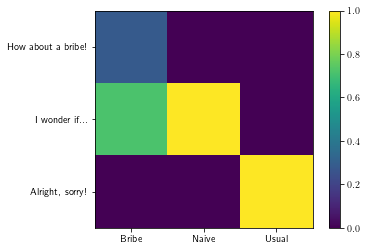

In [52]:
plt.imshow(S_PD)
plt.xticks(ticks=[0,1,2], labels=['Bribe', 'Naive', 'Usual'])
plt.yticks(ticks=[0,1,2], labels=['How about a bribe!', 'I wonder if...', 'Alright, sorry!'])
plt.colorbar()
plt.show()

There is an apparent difficulty with modelling the officer: 
- Consider the listener thinking about a PD listener (in this case, the officer)
- Unless we assume that the listener has a prior for the speaker being a briber ($S_1$) over being naive ($S_2$), there probability of $s_1 \mid u_2$ cannot exceed $s_1 \mid u_1$ (though they can be almost equal at 0.5).
- Is this a problem? That's unclear.
- In a way, this seems right: If being naive was as common as attempting bribery, pretending to be naive wouldn't work as a PD strategy.
- Maybe the point here is: even a _slightly_ higher prior for the guilty $G$ can be exploited by the speaker

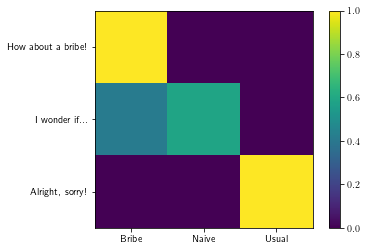

In [54]:
L_PD = normalize(S_PD, 1)

plt.imshow(L_PD)
plt.xticks(ticks=[0,1,2], labels=['Bribe', 'Naive', 'Usual'])
plt.yticks(ticks=[0,1,2], labels=['How about a bribe!', 'I wonder if...', 'Alright, sorry!'])
plt.colorbar()
plt.show()

Some concluding remarks on this example:
- This is the simplest case of PD: 
    - It doesn't involve deception (the speaker is trying to get the listener to recognize the true state)
    - There are just a few, clear options
    - There is a one-to-one correspondence between intentions and possible states
    - Much of the structure is hand-coded rather than structurally emerging from the model
- Nonetheless, it shows some of the fundamental patterns of PD
    - It's an 'anti-implicature': the more general term is chosen over the more specific one
    - Speakers tend to use an utterance to avoid punishment
- The PD speaker can be, from the point of view of PD strategy, a 'level 1' speaker: the objective $G$ doesn't need to include the interpretation of a listener who knows about punishment or a substantial prior over states

## Example: PD w/ degrees and sub-attention, Perfume case

### Setup

(This cell contains text by Michael Franke)

Situation:
- Kiki wants to be liked by Bubu (romantically). 
- Kiki knows that Bubu likes a particular scent. So Kiki puts on that special perfume. 
- But how much of it? Just the right (goldilocks) amount that:
    - Triggers a positive feeling in Bubu 
    - Does not make Bubu realize that Kiki wears the perfume for that reason, since that might not please Bubu.
- (Kiki does not want Bubu to recognize the intention, but just to like the perfume)
- Objection: this is not about being able to deny the true intention. 
    - Okay, but it is about veiling the intention in the first place, so as not to have to deny it. 
    - And then, the less obvious the intention, the easier to deny.

Modelling
- Kiki chooses a non-negative amount of perfume $p$
- There are three thresholds of interest:
  1. effect $\theta_{e}$: if $p > \theta_{e}$ Bubu senses the perfume and feels attracted
  2. perception of perfume: if $p \theta_{p}$ Bubu is conscious of the perfume
  3. realization of intent: $\theta_{i}$: if $p > \theta_{i}$ Bubu becomes convinced that Kiki wants to impress
- Kiki doesn't know where exactly these thresholds lie, but she has a (joint) prior belief about their distribution
- Kiki has payoffs related the possible outcomes:
  1. no-effect: Bubu does not perceive the perfume and is therefore unaffected by it
  2. effect-subconcious: Bubu is affected by the perfume (but doesn't know it)
  3. effect-conscious: Bubu is affected by the perfume and realizes it
  4. detection: Bubu perceives the perfume and comes to believe that Kiki wants to seduce, which is a turn-off
- preference order over outcomes (for Kiki): 2 > 3 >> 1 >> 4
- Kiki's optimal choice of perfume is to stay in the likely range of "effect-subconscious"
- there is veiled intention here
- is there also PD?
  + if Kiki is challenged (by Bubu or another actor) that her degree of perfume choice $p^{*$}$ was a sexualized act, she can PD to the extent that 
      - $p^{*$}$ is a rational choice for an actor without sexual intentions (with different beliefs, preferences and awareness state) 
      - the mental life of this alternative actor is one that Kiki could plausibly have had (including normative considerations about what Kiki may not have been but clearly should have been aware of)

### Modelling

- Set of 'states'
    - It's one dimension: how attracted Bubu is feeling to Kiki (assuming there's a minimum and maximum)
    - [0,1] interval
    - They appear in the $G$ but not in an informativeness measure, as described above
- Set of actions ('non-linguistic utterances') 
    - The amount of perfume that Kiki uses
    - Let's say it's the [0,1] interval
    - 0 being no perfume at all, 1 being the point where perfume is completely perceivable without doubts
    - This can be interpreted kind of 'semantically' in the sense that it excludes worlds: each level of perfume (utterance) is compatible with some levels of attraction (state), though it's presumably a fuzzy semantics. 
        - It's got a word-to-world direction of fit but that's fine from a modelling point of view. 
        - It just means that instead of observing the world state and describing it, the agent chooses one.
    - Let's say that the two are related linearly: amount of perfume $x \in [0,1]$ induces level of attraction x
- Set of intentions of Kiki
    - $G_1$: make Bubu attracted 
    - $G_2$: not make Bubu attracted (wide scope negation)
- Probability of being judged
    - Let's use the same function as in the bribery case above
    - The probability of being punished as an agent having a certain intention is proportional to 1 for all intentions with the minimal punishment among the most likely intentions given the utterance, and proportional to 0 for all other intentions (i.e. non-minimal punishment or not most likely (inclusive or))
        - Basically, this means that there is a level of perfume where Bubu will go "Wait a moment, are you trying something here Kiki?", and any level of perfume up to that point (but excluding that point) has increasing utility
    - The probability of Kiki having each intention (from Bubu's perspective) given a certain level of perfume depends on:
        - Bubu's subjective probability that Kiki is wearing perfume (which is subconscious below a certain level)
        - Bubu's subjective probability of Kiki having the intention given the amount of perfume Bubu perceives on Kiki.
        - Let's simplify these two things into a single function that increases first slowly and then rapidly
- Punishment
    - $G_1$ is punished (let's say, by amount 1)
    - $G_2$ is not punished
    - Interestingly, this is not a realistic description of the situation in general, but it is often how people perceive these situation ("I can't be found out!")
- NOTE: There's more structure to model in this and similar situations, and we can return to it below with the more sophisticated models. This is an initial rough version.

### Implementation

In [6]:
from scipy import stats
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [7]:
plt.rcParams.update({
    "text.usetex": True,
    # "font.family": "Helvetica"
})

In [14]:
attraction = stats.beta(a=2, b=2).cdf
P_G1_given_perfume = stats.beta(a=5, b=2).cdf
punishment = lambda x: P_G1_given_perfume(x) > 0.5 

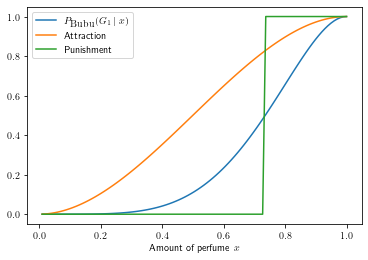

In [15]:
xs = np.linspace(0, 1, 100)[1:]
ys_P = P_G1_given_perfume(xs)
ys_attraction = attraction(xs)
ys_punishment = punishment(xs)
plt.plot(xs, ys_P, label=r'$P_{\textrm{Bubu}} (G_1 \mid x)$')
plt.plot(xs, ys_attraction, label='Attraction')
plt.plot(xs, ys_punishment, label='Punishment')
plt.xlabel(r'Amount of perfume $x$')
plt.legend()
plt.show()

In [16]:
utility = lambda x: (
    # how attracted Bubu feels to Kiki
    attraction(x) 
    # how much punishment Kiki receives for that amount of perfume
    - punishment(x)
)

In [31]:
alpha = 4
unnorm_p_perfume = lambda x: np.exp(alpha*utility(x))
utility_norm = quad(unnorm_p_perfume, a=0, b=1)[0]

p_perfume = lambda x: unnorm_p_perfume(x) / utility_norm

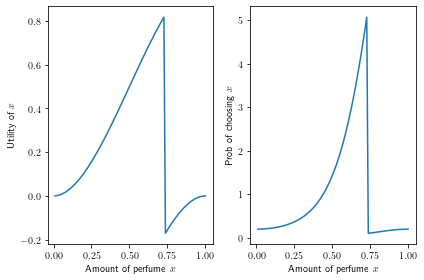

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2)

xs = np.linspace(0, 1, 100)[1:]

ax1.plot(xs, utility(xs))
ax1.set_ylabel(r'Utility of $x$')

ax2.plot(xs, p_perfume(xs))
ax2.set_ylabel(r'Prob of choosing $x$')

[ax.set_xlabel(r'Amount of perfume $x$') for ax in [ax1, ax2]]

plt.tight_layout()
plt.show()

## Example: Strategic flattery

(Note: This cell contains text by Michael Franke)

- Kiki wants to ask Bubu for a favor. 
- So Kiki says many nice things to Bubu and is really polite and friendly. 
- But how much courtesy is too much? The point where the intention of Kiki to prepare Bubu for asking a favor becomes apparent.

- I think it's easier to model intensity of compliments rather than number of them.
- Utterances:
    - Your risotto was good
    - Your risotto was extraordinary
- 'States':
    - [0,1] interval
- TODO

# Refinement 2: Speaker error

Let's add the possibility for the judge that the denying speaker might not have correctly recognized the true state.

\begin{align}
U_{S}(u ; s) = & & \text{Utility of } s \text{ given } u \text{ for } S \\
+ \beta \, & \log \left( p_{L}(s \mid u) \right) & \text{Informativity} \\
+ \gamma \, & G( u ; s )  & \text{Utility of } u \text{ given } s \text{ for } S \\
- \delta \, & \sum_{i \in \Sigma} \left( P_J(S \text{ believes } i \mid s) \sum_{\hat{G}} \left( P_{J}(\hat{G} \mid u, i) U_J(\hat{G}, i) \right) \right) & \text{Risk of } u \text{ given } s \text{ for } L_1 \text{ (with judge $J$)} \\
- \, & C(u) & \text{Utterance cost of } u
\end{align}

- $P_J(S \text{ believes } i \mid s)$: 
    - The probability (according to the judge as imagined by the speaker) that the speaker believes $i$, given that the true state is $s$.
    - If the speaker thinks that the judge thinks that the speaker is not informed, the speaker can use this to their advantage, because then the utterance might not suggest a non-cooperative strategy anymore.
    - This will show up again with PD and heding or modals
- $\Sigma$ (used below) is the set of states

# Refinement 3: Speaker ignorance

## Model description

In this, the speaker assumes a judge who is not sure about the speaker's knowledge state. In such cases the speaker can PD by claiming ignorance. In other words, the PD speaker can propose an alternative story where they didn't know the way things really were.

- Whether the speaker can get away with doing this is an empirical question!
- In general, the speaker needs to assess whether an alternative speaker is acceptable or not.
- In this case it's going to depend on the judge's assessment of the possibility that the speaker 
- We can model this case exactly as the basic case above, but instead of punishing by the minimum punishment amongst the ones given for the most likely _intentions_, the judge punishes by the minimum punishment amongst the most likely intention given every possible knowledge state
- The denial strategy here would be expressed linguistically as "But I thought that..." / "I wasn't sure whether..."

## Example: Paltering (Notes)

In [ ]:
def calculate_S1_J(L0, possible_Gs, alpha, beta, gamma, costs):
    """
    The judge's model of the speaker
    
    Parameters
    ----------
    possible_Gs: array
        Dimensions: (G, utterance, state)
        Records for each G
        the probability of S producing each utterance given each state
    L0: array
        Dimensions: (utterance, state)
    """
    # dimensions: (G, utterance, state)
    # encodes the probability of u given the speaker's belief in the first dimension
    # which is also the unnormalized probability of each strategy (second dimension)
    softmax_across_us = softmax(
        beta*L0[None] + gamma*possible_Gs - costs[None,:,None],
        alpha,
        # normalize across utterances
        axis=-2
    )
    return np.nan_to_num(softmax_across_us)

### Speaker's goal

- $G$ aims for $L$ to form a certain goal-belief $\sigma$ that might not be the one she knows to be true.
    - This is socially unacceptable, as a general principle, and therefore if an accusation happens is punished unless successfully denied
    - We assume that it's convenient for the speaker that the listener has certain beliefs, independently of what the true state is. Therefore, $G$ does not depend on the speaker's belief state (though it might happen that by chance $\sigma$ is identical to $i$)
        - In general, it can be otherwise. For instance it's possible that the speaker might want the listener to form a systematically false belief _as such_, which depends on what the speaker takes the true state to be (think e.g. competitive games like battleship).
    - though the _punishment_ depends on the speaker's belief state
    - For notational simplicity I write $G(u)$
- $G$ simply tries to convince the $L_0$ of $\sigma$. Let's write this type of $G$ as $G_{\sigma}$:

$$
G_{\sigma}(u) = \log P_{L}(\sigma \mid u)
$$

- This of course makes it impossible that the speaker would produce an utterance that's not compatible with the goal belief to induce
    - This is a simplification, but for now it can be thought of as "If there's no utterance that's convenient for the speaker, the speaker would rather stay silent" (where silence is compatible with everything)

### The punishment function

- For a given $G$, the judge punishes (by 1) any $G$ that aims to do anything other than attempting to convey the truth (where $s$ is the speaker's believed state), and doesn't punish otherwise:

$$
U_J(G_\sigma, s) = [ \sigma \not= s]
$$
    
- This means that the judge punished any systematic misleadingness, even if the speaker is only interested in only one specific way of being misleading.
    - This makes sense intuitively, even though in reality some ways of being misleading might be worse than others!

In [ ]:
def calculate_possible_Gs(informativity):
    """
    returns array that encodes the usefulness of u given s for each sigma
    Each G is encoded as an array with dimensions (utterance, state), i.e. (utterance, speaker's belief)
    There is one G for each possible value of sigma, and therefore:
    The dimensions of possible_Gs is (sigma, utterance, speaker's belief), i.e. (state, utterance, state)
    """
    return np.tile(
        informativity.T[:,:,None], 
        (1,1,informativity.shape[-1])
    )

In [11]:
def calculate_punishment(L0, possible_Gs, alpha, beta, gamma, costs, speaker_f=calculate_S_J):
    """
    This function returns for each speaker belief the punishment for each strategy
    Returns array with shape (state, state, utterance, state), i.e. (speaker's belief, sigma, utterance, speaker's belief)
    """
    
    # Dimensions: (sigma, utterance, state)
    S1_J = speaker_f(
        L0, 
        alpha, 
        costs
    )
    
    # Q to answer: given an utterance and a belief, is any of the most likely strategies not misleading?
    
    # First, calculate the most likely strategies:
    # Is each strategy among the most likely, given
    # each combination of utterance and state?
    # (note that there can be more than equally most likely, 
    # so it's a boolean mask)
    most_likely = (S1_J.max(axis=0, keepdims=True) == S1_J)
    
    # Second, calculate if each strategy is misleading
    # (i.e., if sigma equals the state)
    sigma_index, _, state_index = np.indices(most_likely.shape)
    misleading = sigma_index != state_index
    
    # Third, calculate material conditional: 
    # if a strategy is among the most likely ones, is it misleading?
    # I.e. find strategies that are most likely AND not misleading
    material_conditional = most_likely & ~misleading
    
    # Finally, check that for each combination of state and signal
    # At least one of the most likely strategies is not misleading
    punishment_avoidable = material_conditional.any(0)
    
    return (~punishment_avoidable).astype(int)

# Refinement 4: Alternative blameless speakers

In a more general way, PD often relies not on showing that the speaker was mistaken about the truth, but rather on the speaker arguing that they are in some different from what the listener had assumed. There are many types of possible differences, but they ultimately all have to do with the speaker qua conditional distribution over utterances given a state and an intention.

\begin{align}
U_{S}(u ; s) = \\
+ \beta \, & \log \left( p_{L}(s \mid u) \right) \\
+ \gamma \, & G( u ; s ) \\
- \delta \, & \sum_{\hat{G} \in \Gamma, \, \zeta \in Z} \left( P_{J}(\hat{G} \mid u, s, z) U_J(\hat{G}, s) \right) \\
- \, & C(u) 
\end{align}

- $Z$ is a set of possible speakers (functions from knowledge states to distributions over utterances)
- Now $P_J$ is also considers a particular speaker that might not be the same as the real speaker
    - E.g. $Z$ might be $\{ L_0, L_1 \}$
    - Or $Z$ might be $L_1$ parameterized by $\alpha$
    - Or the speakers in $Z$ might have slightly different interpretation functions

## Example: Dogwhistles

# Refinement 5: A PCFG for speakers (i.e. a _space_ of excuses)

TODO

- The intuition here is that the task of the PD speaker is to _come up_ with (/ construct) an excuse that will let them get away with the utterance. 
- This excuse takes the form of an alternative speaker that the PD speaker can claim to really have been. 
- As long as _one_ such blameless hypothetical speaker can be constructed, the PD can be successful 
    - This is why in specific cases of PD above we have a feeling that the alternatives are oddly unrelated: there is the true alternative and then some constructed alternative. Further alternatives are useless.
    - TODO: I have a rough intuition that this makes the recognition of PD something like a Monty Hall problem. To think about.
- From a cognitive point of view, the task can then be formulated as: construct a blameless speaker who would have produced your behaviour with a probability at least as high as yours.
- This construction means exploring a space of possible speakers, with some constraints 
    - They have to be possible speakers from the judge's point of view
    - They have to be such that they would have likely produced the utterance.
- A natural way of modelling this construction process is with a PCFG of speakers 
    - Though it might have to be quite a rich grammar
    - The task is not to find a full posterior over PCFGs, but rather a single one that satisfies certain conditions. This can make the search easier.
    - Though there might be multiple options and local maxima. 
    - Simulated annealing might be a natural choice here. 
- This can explain another wrinkle in PD:
    - A common strategy is to construct a blameless speaker that the listener isn't even considering
    - And then if we need to plausibly deny, we _expand_ the space of speakers that the listener considers.
        - This relies on the fact that the judge punishes wrt to all the options we can conjure when we deny, not wrt to the ones that were available at utterance time. 
- TODO: Think of a good illustrative example of this!

# Notes (Disregard)

- Question: is there more structure in $R$ and $G$ across all cases of PD? Hypothesis: In most cases of PD $R$ can be naturally modelled as an RSA listener of various kinds.
- The model points to the symmetric case to PD: sometimes there's no utterance that doesn't mislead the judge in terms of what $G$ is. In other words, it's hard for the speaker to convey something without giving a false impression and be punished for it.
- Possible experiment

- Experiments that simulate the production/understanding of utterances that do something that’s plausible deniable
    - Simulated courtroom cross-examination
    - Simulated insurance contract
    - Simulated dogwhistles 
    - Two groups of listeners with misaligned interests
    - One group has punishing power, the other has supporting power
- Experiments that simulate the production/understanding of denial of previously done (possibly linguistic) actions 
    - Pedantry
    - Listener deniability (which is the deniability of an interpretation)

- Difference between conditions
    - Listener’s awareness of the degree of cooperation / speaker’s RSA utility

- Paltering experiment
    - Have people _answer questions_ in a mock trial with knowledge of situation & guilt, see what alternative speakers they construct online while avoiding lies
    - Like a simulated Bill Clinton

## Some cases

- Covert aggression
- Deceiptful implicatures
- Dogwhistles
- Bribery
- Flirting

## Other cases

- "Addressee-recognition PD" (ARPD): $G$ depends on the (espected probability of the) addressee forming a certain belief (based on the speaker's utterance) about the speaker's mental state (beyond settling the world state described by the utterance. See below). 
    - Examples of ARPD: $G$ aims for the listener the come to believe that the speaker...
        - has certain communicative intentions (covert insults)
        - has certain desires (indirect requests)
    - The point here is that $G$ can be modelled as a listener that does joint inference on the state and the way the speaker is
    - Depending on one's account of how assertion works (how propositions are added to the common ground), misleading implicatures might belong here. 
        - Depending on one's answer to the q: does a listener come to believe the content of an utterance through the belief that the speaker believes what they asserted + trust? Or are there default mechanisms in the normal case?
        - This doesn't matter too much for the modelling.
    - In ARPD the listener is co-inferring world-state and some parameter $\phi$ that describes something about the speaker (e.g. their intentions / beliefs / desires / some other feature of their identity).
    - The speaker intends for the listener to infer some specific value of $\phi$.
    - The belief to induce in the listener might be accurate (e.g. flirting, attempted bribery) or inaccurate (e.g. misleading implicatures)
    - Again, $G$ doesn't depend on the true state $s$
- belonging to a certain social group (dogwhistles)
    - Dogwhistles (arguably) don't belong to ARPD because (at least distally) they don't aim for the listener to recognize a mental state in the speaker, but rather some social fact about the speaker
- E.g., scenario: A is talking to B and C is overhearing. A knows that C is overhearing and B doesn't. A intentionally conveys something hidden to C by talking to B, without B realizing that that is happening. (Arguably C is also a "listener" in the relevant sense, arguably not. It doesn't matter too much for the model)

## Covert aggression 
- Take the simplest imaginable case where one might want to convey something different from the truth in a PD way.
    - I try some food made by someone I don't like but I'm on polite terms with 
    - (I can't be overly aggressive but I can do a covert insult) 
    - They ask me what I thought of the food.
    - Possible utterances: "It tasted bad" | "It tasted good" | "It was edible"
- (TOTHINK: What does the Yoon model predict in this context??)